# DCO Distances

In [1]:
import astropy.units as u
from astropy.visualization import quantity_support
quantity_support()
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, LogNorm
from astropy.coordinates import SkyCoord
import astropy.constants as const

import numpy as np
import pandas as pd
import healpy as hp
import gala.dynamics as gd
import gala.units as gu

import legwork

import kicker

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.9 * fs,
          'ytick.labelsize': 0.9 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

# Create a test population

In [4]:
p = kicker.pop.Population(n_binaries=100000, m1_cutoff=7)
p.create_population()

Run for 100000 binaries
Ended up with 1547 binaries with m1 > 7 solar masses
[1e+00s] Sample initial binaries
[11.1s] Evolve binaries (run COSMIC)


100%|███████████████████████████████████████| 1547/1547 [00:26<00:00, 58.32it/s]


[38.9s] Get orbits (run gala)
Overall: 51.4s


# Future Mergers

## Where are DCOs at present day?

In [117]:
dcos = p[p.classes[p.classes["dco"]].index.values]

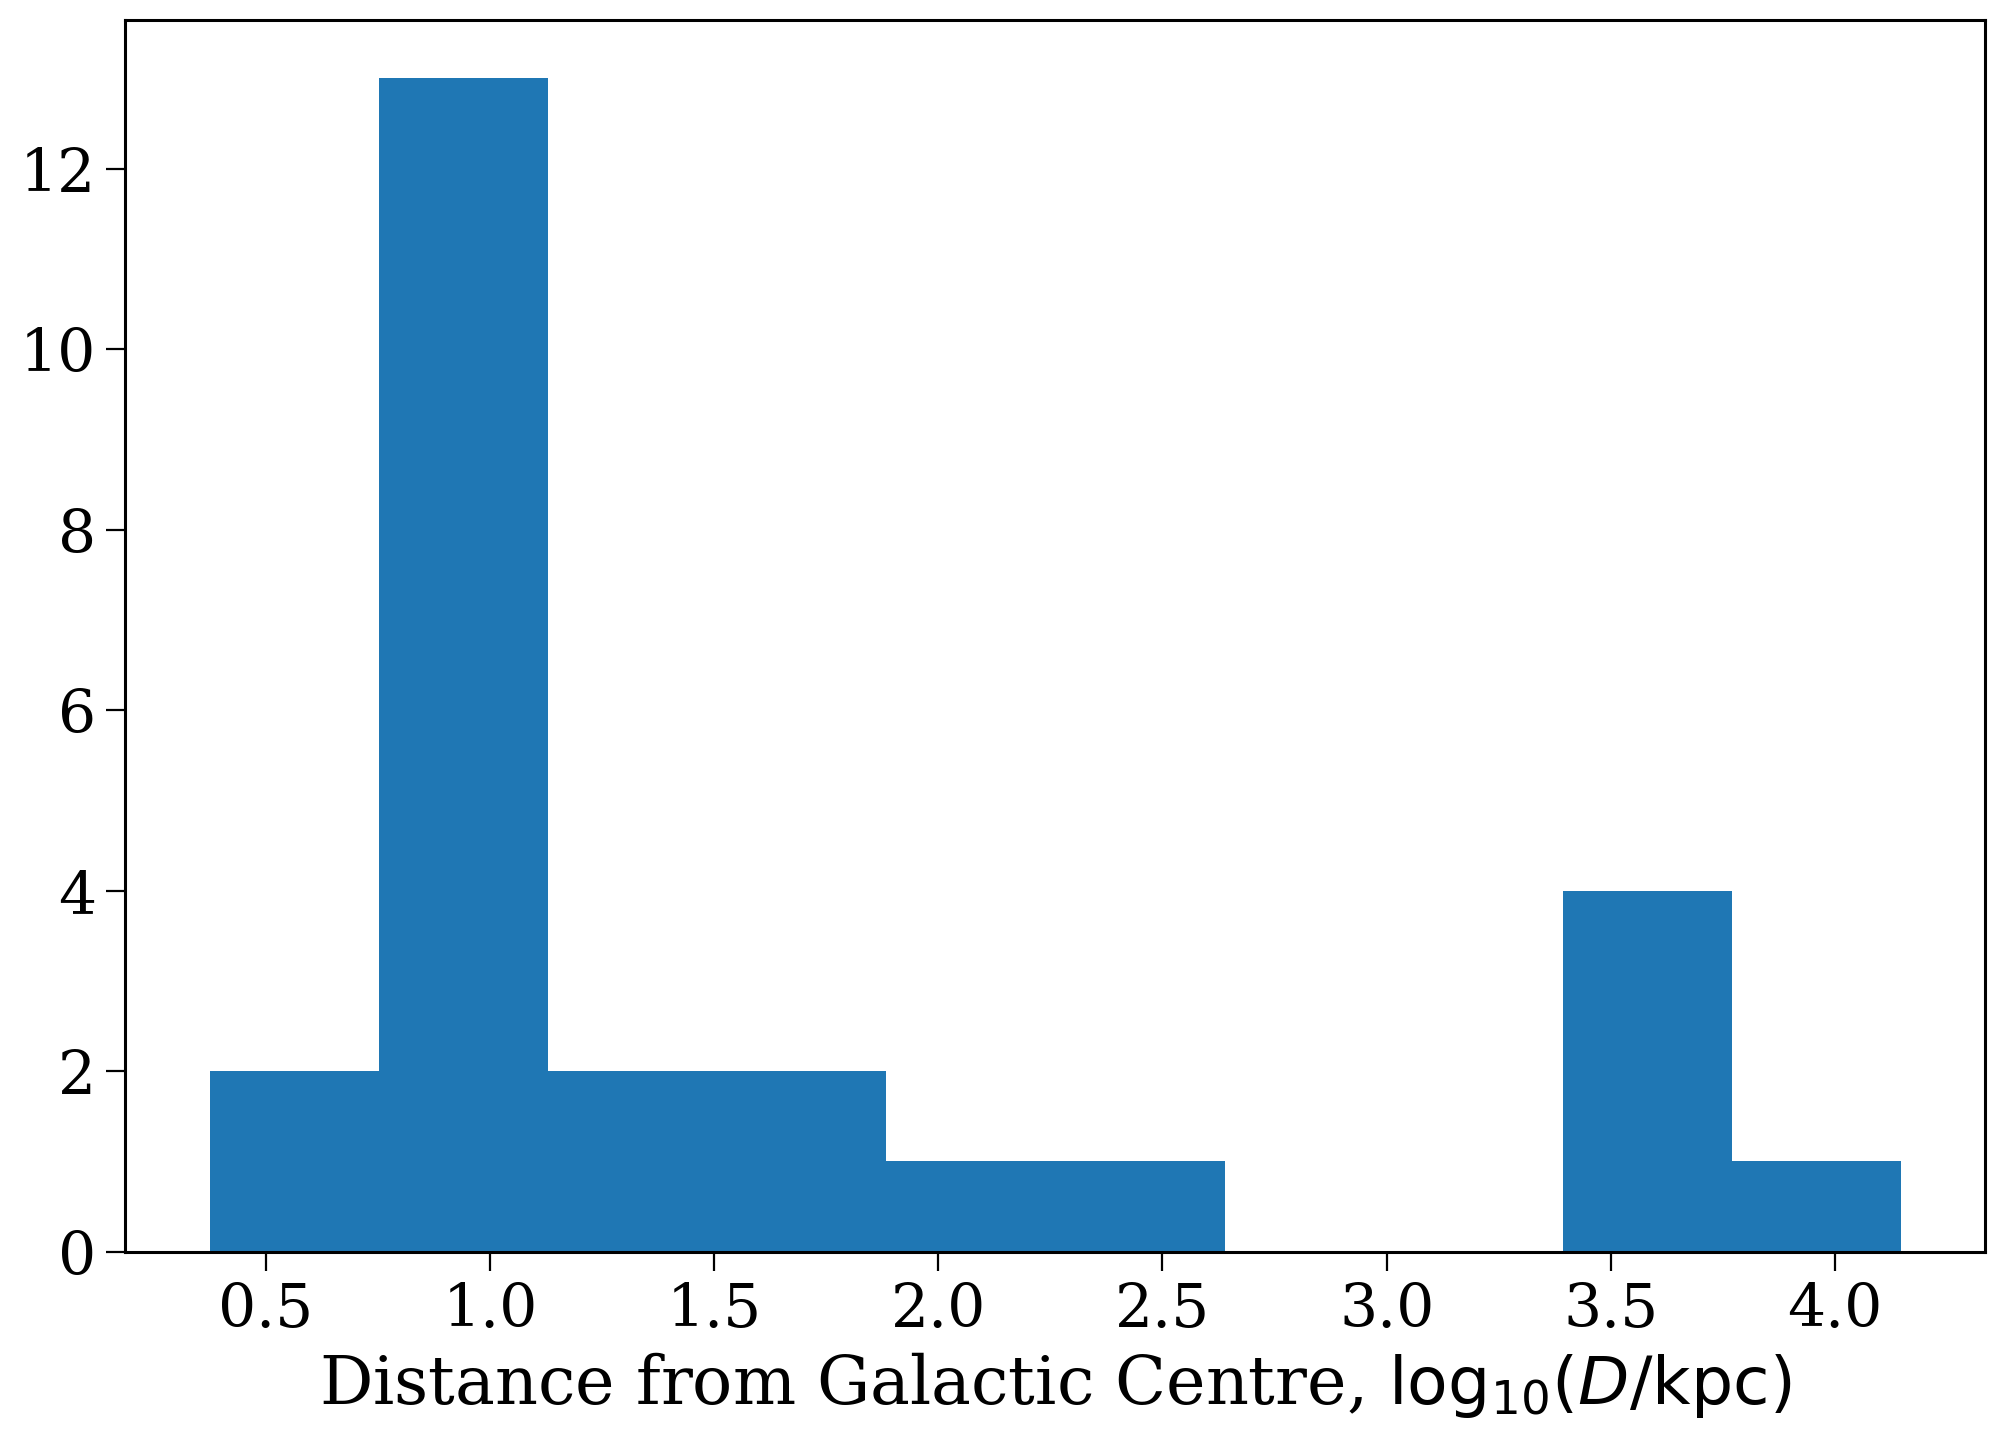

In [127]:
plt.hist(np.log10(dcos.final_coords[0].icrs.distance.to(u.kpc).value))
plt.xlabel(r"Distance from Galactic Centre, $\log_{10}(D/{\rm kpc})$")
plt.show()

## When will they merge?

In [6]:
t_merge = legwork.evol.get_t_merge_ecc(ecc_i=dcos.final_bpp["ecc"].values,
                                       a_i=dcos.final_bpp["sep"].values * u.Rsun,
                                       m_1=dcos.final_bpp["mass_1"].values * u.Msun,
                                       m_2=dcos.final_bpp["mass_1"].values * u.Msun)

## _Where_ will they merge?

I've only considered things merging in the next Tyr which is still probably still too lax.

### For escaped DCOs, just move linearly

In [7]:
def get_escaped(s):
    escaped = [np.repeat(False, len(s)), np.repeat(False, len(s))]
    
    for ind, mask in enumerate([np.repeat(True, len(s)), s.disrupted]):
        pos = np.asarray([s.final_coords[ind][mask].galactocentric.x.to(u.kpc),
                          s.final_coords[ind][mask].galactocentric.y.to(u.kpc),
                          s.final_coords[ind][mask].galactocentric.z.to(u.kpc)]) * u.kpc
        v_curr = np.sum(s.final_coords[ind][mask].velocity.d_xyz**2, axis=0)**(0.5)
        v_esc = np.sqrt(-2 * s.galactic_potential(pos))
        escaped[ind][mask] = v_curr >= v_esc
    return escaped

In [139]:
esc = get_escaped(dcos)[0]
esc_dcos = dcos[dcos.bin_nums[esc]]
gal_dcos = dcos[dcos.bin_nums[~esc]]

In [239]:
future_mergers = np.zeros((len(dcos), 3)) * u.kpc

In [240]:
movement = (esc_dcos.final_coords[0].velocity * t_merge[esc]).d_xyz.to(u.kpc)
future_mergers[esc] = (np.asarray([esc_dcos.final_coords[0].x.to(u.kpc),
                                   esc_dcos.final_coords[0].y.to(u.kpc),
                                   esc_dcos.final_coords[0].z.to(u.kpc)]) * u.kpc + movement).T

### For DCOs still bound to the galaxy, integrate orbits

In [203]:
import gala.integrate as gi

In [242]:
for i, bin_num in enumerate(dcos.bin_nums):
    if not esc[i] and t_merge[i] < 1000 * u.Gyr:
        start_time = dcos.final_bpp.tphys[bin_num] * u.Myr
        print(start_time, t_merge[i])
        final = dcos.galactic_potential.integrate_orbit(dcos.orbits[i][-1], t1=start_time,
                                        t2=start_time + t_merge[i], dt=1 * u.Myr,
                                        store_all=False, Integrator=gi.DOPRI853Integrator)
        print(final.pos.xyz.ravel())
        future_mergers[i] = final.pos.xyz.ravel()

11520.648934129866 Myr 982.8469318282864 Gyr
[  3.36394978 -34.92891323  44.24726904] kpc


In [243]:
future_mergers[t_merge < 1 * u.Tyr]

<Quantity [[ 3.36394978e+00, -3.49289132e+01,  4.42472690e+01],
           [-2.16409708e+05, -2.28822024e+05,  2.40011655e+05]] kpc>

In [245]:
future_merger_distances = np.sum(future_mergers[t_merge < 1 * u.Tyr]**2, axis=1)**(0.5)
future_merger_distances

<Quantity [5.64727010e+01, 3.95977619e+05] kpc>

# Past mergers

In [66]:
merged = p.bpp[p.bpp["sep"] == 0].index.unique()
ever_bhbh = p.bpp[(p.bpp["kstar_1"] == 14) & (p.bpp["kstar_2"] == 14)].index.unique()
bhbh_mergers = p[np.intersect1d(merged, ever_bhbh)]

In [261]:
present_times = bhbh_mergers.final_bpp["tphys"].values * u.Myr
merger_times = bhbh_mergers.bpp[(bhbh_mergers.bpp["kstar_1"] == 14)
                              & (bhbh_mergers.bpp["kstar_2"] == 14)].drop_duplicates(subset="bin_num", keep="last")["tphys"].values * u.Myr

In [265]:
past_mergers = np.zeros((len(bhbh_mergers), 3)) * u.kpc
for i in range(len(bhbh_mergers)):
    past_mergers[i] = bhbh_mergers.galactic_potential.integrate_orbit(bhbh_mergers.orbits[i][-1],
                                                                      t1=present_times[i],
                                                                      t2=merger_times[i], dt=-1 * u.Myr,
                                                                      store_all=False,
                                                                      Integrator=gi.DOPRI853Integrator).pos.xyz.ravel()

In [274]:
past_merger_distances = np.sum(past_mergers**2, axis=1)**(0.5)
past_merger_distances

<Quantity [3.84099714e+01, 1.84357495e+03, 2.93885312e+01, 1.32127646e+02,
           2.33856229e+02, 1.17624753e+02, 5.49021676e+00, 2.23260475e+01,
           1.76880293e+02, 8.41909347e+03, 6.16811951e+02] kpc>

In [273]:
future_merger_distances

<Quantity [5.64727010e+01, 3.95977619e+05] kpc>

# READ STUFF

In [446]:
dfs = [pd.read_hdf(f"data/merger-loc-times-{i}.h5") for i in range(10)]
df = pd.concat(dfs)
df = dfs[0]
df["distance"] = np.sqrt(df["x"]**2 + df["y"]**2 + df["z"]**2)
df.set_index("bin_num", inplace=True)

In [106]:
p = kicker.pop.load("/epyc/ssd/users/tomwagg/pops/dco_mergers/merger-distance-pop-0")

In [108]:
p.bin_nums

array([    31,    298,    349, ..., 151622, 151722, 151795])

In [121]:
from collections import Counter

In [127]:
p.bpp.loc[31]

,tphys,mass_1,mass_2,kstar_1,kstar_2,sep,porb,ecc,RRLO_1,RRLO_2,evol_type,aj_1,aj_2,tms_1,tms_2,massc_1,massc_2,rad_1,rad_2,mass0_1,mass0_2,lum_1,lum_2,teff_1,teff_2,radc_1,radc_2,menv_1,menv_2,renv_1,renv_2,omega_spin_1,omega_spin_2,B_1,B_2,bacc_1,bacc_2,tacc_1,tacc_2,epoch_1,epoch_2,bhspin_1,bhspin_2,bin_num
31,0.000000,25.115070,22.053608,1.0,1.0,1652.372035,1.133462e+03,0.791689,4.084343e-02,0.040077,1.0,0.000000,0.000000,7.766507e+00,8.897592e+00,0.000000,0.000000,5.486010,5.072718,25.115070,22.053608,7.300273e+04,5.264686e+04,40688.914515,38993.511495,0.000000,0.000000,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.895891e+03,2.059813e+03,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,31
31,7.807230,24.775591,21.880445,2.0,1.0,1670.527343,1.158507e+03,0.791689,1.006756e-01,0.082079,2.0,7.873520,7.848858,7.873519e+00,8.974640e+00,7.330972,0.000000,13.653617,10.517212,24.775591,21.880445,1.952973e+05,1.116366e+05,32985.252573,32679.165918,0.773006,0.000000,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,3.889817e+02,4.502972e+02,0.0,0.0,0.0,0.0,0.0,0.0,-0.066290,-0.041628,0.0,0.0,31
31,7.818873,24.770209,21.880024,4.0,1.0,1670.715417,1.158775e+03,0.791687,6.280945e-01,0.082319,2.0,7.885163,7.860667,7.873519e+00,8.974829e+00,7.477581,0.000000,85.188648,10.549722,24.775591,21.880024,2.291868e+05,1.118188e+05,13744.412020,32642.080799,0.782577,0.000000,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,7.567074e+00,4.474624e+02,0.0,0.0,0.0,0.0,0.0,0.0,-0.066290,-0.041794,0.0,0.0,31
31,8.079694,24.593423,21.875119,4.0,1.0,349.251999,1.109688e+02,0.000000,1.000785e+00,0.088317,3.0,8.145984,8.123441,7.873519e+00,8.977036e+00,8.215623,0.000000,136.001086,11.376440,24.775591,21.875119,2.446987e+05,1.160857e+05,11057.483920,31729.347017,0.884151,0.000000,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,2.068032e+01,2.068032e+01,0.0,0.0,0.0,0.0,0.0,0.0,-0.066290,-0.043747,0.0,0.0,31
31,8.261748,8.800959,37.478798,4.0,1.0,881.144357,4.456021e+02,0.000000,9.441495e-01,0.021244,4.0,8.328038,2.994024,7.873519e+00,5.494933e+00,8.730777,0.000000,218.870042,9.487800,24.775591,37.478798,2.546816e+05,2.690932e+05,8803.914802,42870.892315,0.949810,0.000000,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,2.959855e-13,4.142947e+03,0.0,0.0,0.0,0.0,0.0,0.0,-0.066290,5.267724,0.0,0.0,31
31,8.274697,8.767411,37.486815,7.0,1.0,881.127358,4.457122e+02,0.000000,4.119151e-03,0.021277,2.0,0.411006,3.006505,7.084502e-01,5.494074e+00,0.000000,0.000000,0.953822,9.508966,8.767411,37.486815,1.382120e+05,2.697790e+05,114464.893429,42850.410192,0.000000,0.000000,8.767411e+00,1.000000e-10,9.538223e-01,1.000000e-10,2.951652e-05,4.120982e+03,0.0,0.0,0.0,0.0,0.0,0.0,7.863692,5.268192,0.0,0.0,31
31,8.575192,8.517887,37.420288,8.0,1.0,887.187069,4.518644e+02,0.000000,3.665836e-03,0.022131,2.0,0.723737,3.311107,7.237364e-01,5.501216e+00,5.725042,0.000000,0.848394,10.004959,8.517887,37.420288,1.605693e+05,2.823957e+05,126004.642733,42254.842036,0.000070,0.000000,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.267166e-02,3.670665e+03,0.0,0.0,0.0,0.0,0.0,0.0,7.851455,5.264085,0.0,0.0,31
31,8.607377,8.477256,37.412771,8.0,1.0,888.117566,4.528128e+02,0.000000,3.665836e-03,0.022131,15.0,0.755188,3.343035,7.237364e-01,5.502007e+00,6.219971,0.000000,1.030335,10.062209,8.517887,37.412771,2.430585e+05,2.837795e+05,126825.964620,42185.986175,0.000070,0.000000,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.128852e+07,3.623391e+03,0.0,0.0,0.0,0.0,0.0,0.0,7.851455,5.263596,0.0,0.0,31
31,8.607377,3.934654,37.412771,14.0,1.0,32903.969043,1.075772e+05,0.973063,8.970555e-08,0.019775,2.0,0.000000,3.343781,7.237364e-01,5.502025e+00,3.934654,0.000000,0.000017,10.063558,8.517887,37.412771,1.000000e-10,2.838120e+05,4488.832569,42184.362999,0.000017,0.000000,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.128852e+07,3.622288e+03,0.0,0.0,0.0,0.0,0.0,0.0,8.607377,5.263596,0.0,0.0,31
31,10.779165,3.934654,36.750543,14.0,2.0,33420.475990,1.110128e+05,0.9

(array([1.341e+03, 2.190e+02, 8.600e+01, 3.400e+01, 1.300e+01, 7.000e+00,
        1.000e+00, 2.000e+00, 1.000e+00, 1.000e+00]),
 array([2.02360849e-01, 8.04064353e+01, 1.60610510e+02, 2.40814584e+02,
        3.21018659e+02, 4.01222733e+02, 4.81426807e+02, 5.61630882e+02,
        6.41834956e+02, 7.22039031e+02, 8.02243105e+02]),
 <BarContainer object of 10 artists>)

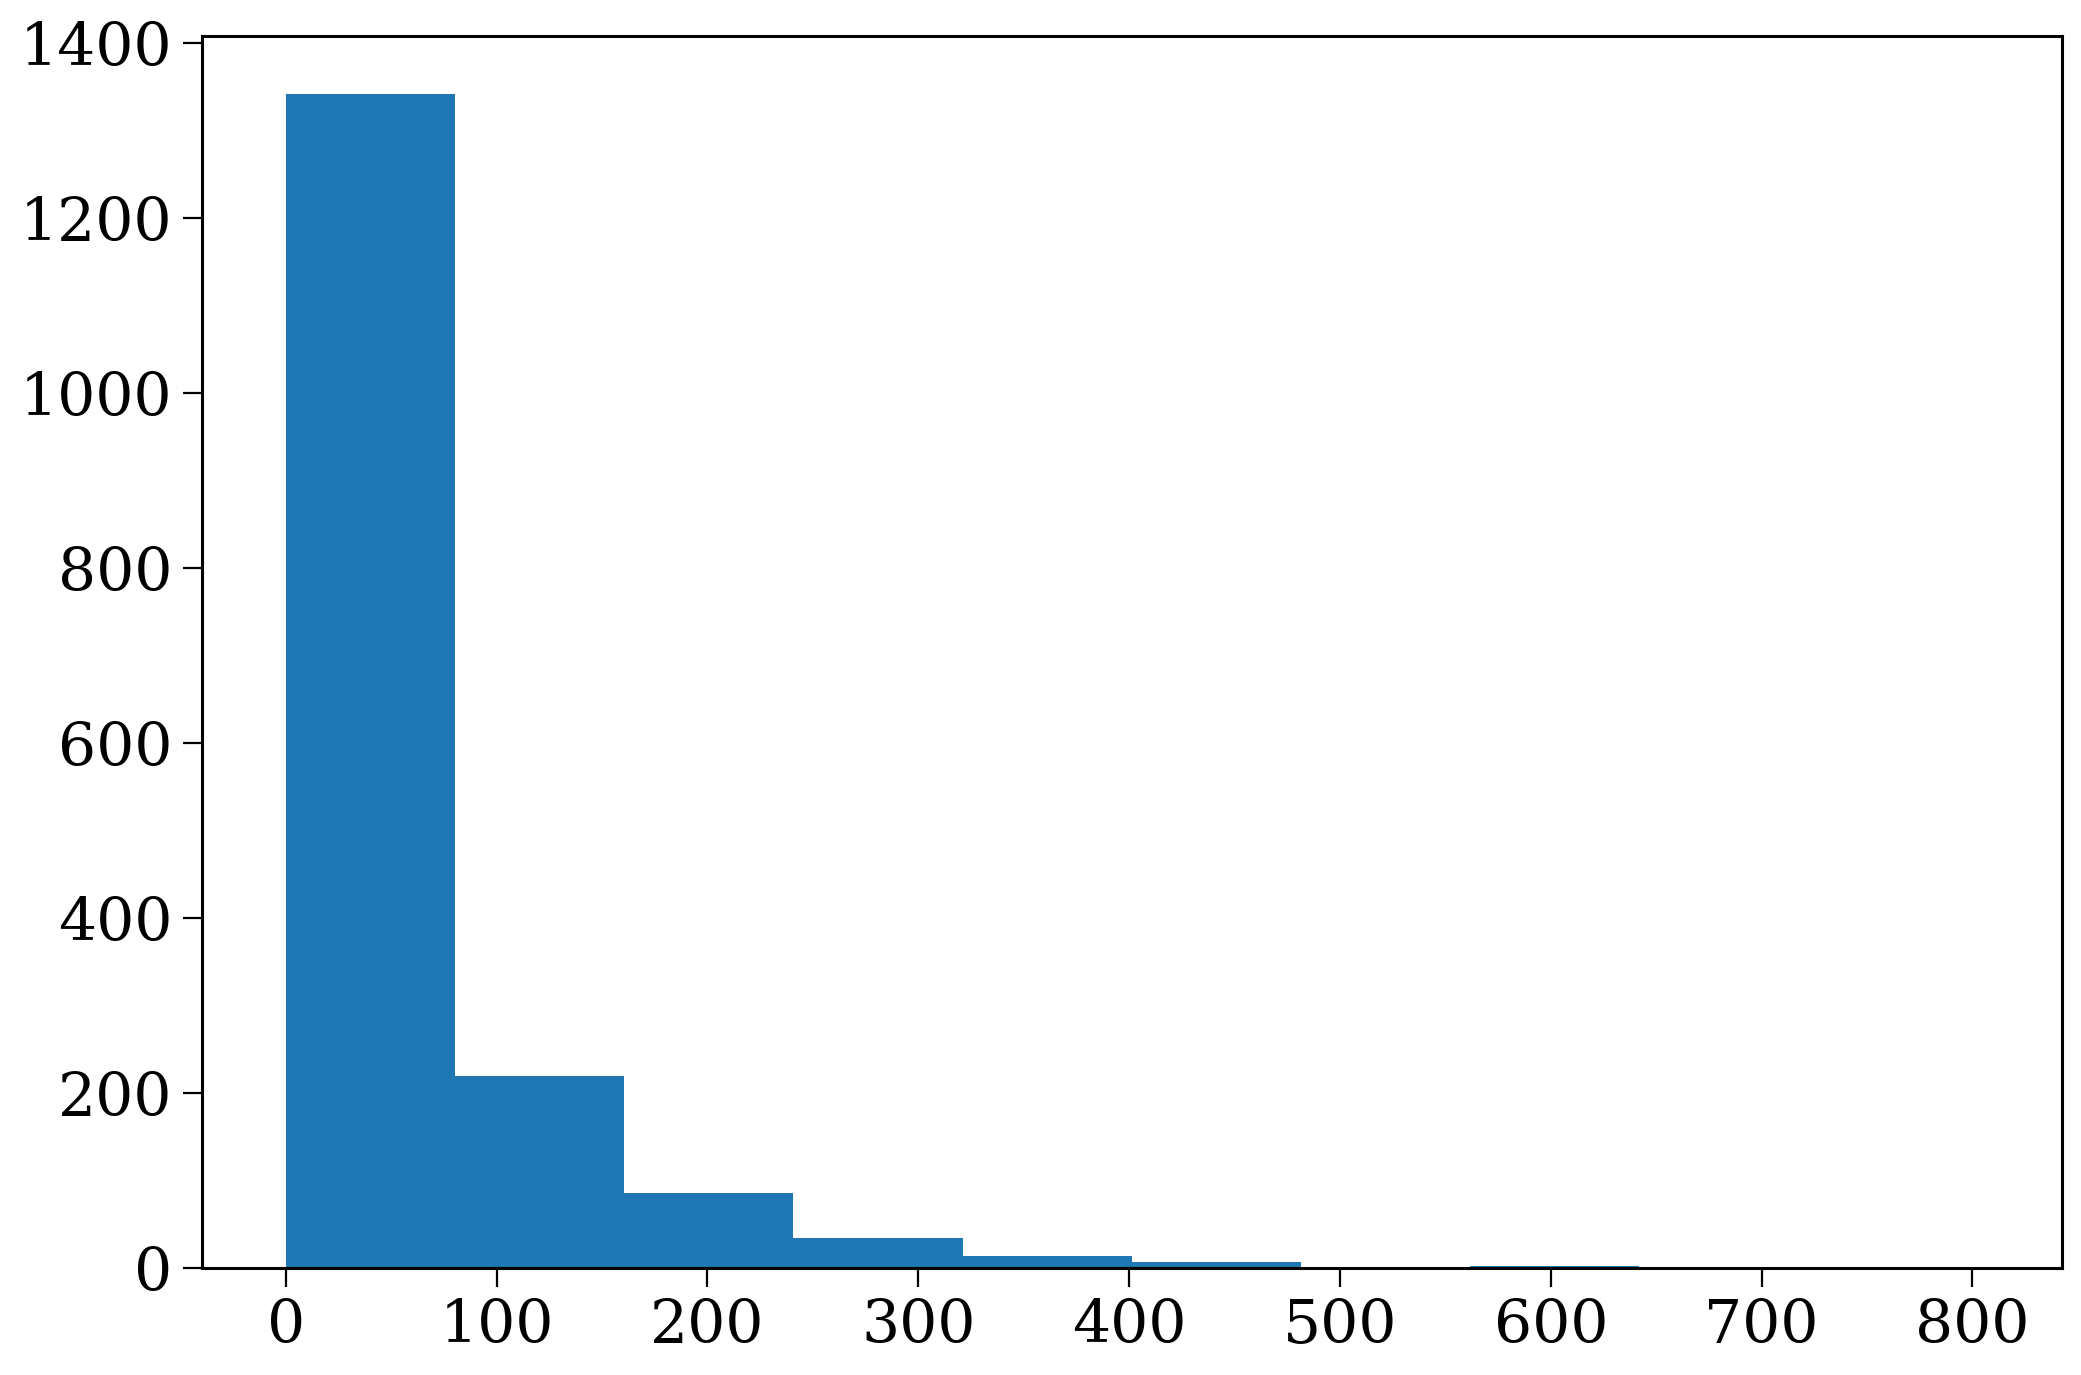

In [133]:
plt.hist(p.kick_info.drop_duplicates(subset="bin_num", keep="last")["vsys_1_total"])

In [125]:
p.final_coords[0]

<SkyCoord (Galactocentric: galcen_coord=<ICRS Coordinate: (ra, dec) in deg
    (266.4051, -28.936175)>, galcen_distance=8.122 kpc, galcen_v_sun=(12.9, 245.6, 7.78) km / s, z_sun=20.8 pc, roll=0.0 deg): (x, y, z) in kpc
    [( 1.41018534e+04,  9.67720418e+03,  1.60817228e+04),
     (-3.96299904e+03,  9.79175054e+03,  1.17871513e+03),
     ( 2.26217532e+03, -7.31440727e+02, -1.62967605e+03), ...,
     (-6.81671764e+00, -2.76953401e+00,  1.29475946e-01),
     ( 3.20941194e+02,  4.72609946e+03, -6.20018055e+03),
     ( 8.98102698e+03,  1.56686672e+04, -2.80859805e+03)]
 (v_x, v_y, v_z) in km / s
    [(1233.20329173,  846.33968684,  1407.01569983),
     (-347.82227172,  858.06944648,   103.07678383),
     ( 287.25921308,  -93.83151046,  -207.0358606 ), ...,
     ( 182.97332817,   46.17416603,   -71.27737604),
     (  76.08911112, 1125.32255425, -1479.33382777),
     ( 956.63229321, 1671.46619867,  -299.12050256)]>

In [124]:
Counter(p.initial_galaxy.which_comp)

Counter({'high_alpha_disc': 919, 'low_alpha_disc': 551, 'bulge': 235})

In [114]:
p.kick_info

,star,disrupted,natal_kick,phi,theta,mean_anomaly,delta_vsysx_1,delta_vsysy_1,delta_vsysz_1,vsys_1_total,delta_vsysx_2,delta_vsysy_2,delta_vsysz_2,vsys_2_total,delta_theta_total,omega,randomseed,bin_num
31,1.0,0.0,68.094136,76.131209,158.920219,221.277394,-8.127980,2.339044,-4.868690,9.759064,0.0,0.0,0.0,0.0,30.006797,2.935741,-1.573730e+09,31.0
31,2.0,0.0,31.724512,25.362566,359.381633,55.126063,53.229250,-66.188971,-27.897914,84.761950,0.0,0.0,0.0,0.0,30.602634,0.065901,1.462082e+09,31.0
298,1.0,0.0,56.481630,45.363656,342.297721,191.613386,-3.992144,3.574462,12.104381,13.237448,0.0,0.0,0.0,0.0,40.574516,14.418539,-8.981860e+08,298.0
298,2.0,0.0,69.724392,54.707242,108.634754,37.090257,35.548900,-8.096352,-19.831658,32.802243,0.0,0.0,0.0,0.0,47.018688,2.427115,2.034174e+09,298.0
349,1.0,0.0,100.592522,-58.036791,356.184933,103.661638,8.424441,4.012549,-8.732129,12.779743,0.0,0.0,0.0,0.0,64.446481,4.962750,-1.299742e+09,349.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151622,2.0,0.0,0.000000,34.350710,322.595587,250.234544,-1.637004,0.595642,-0.754016,2.619406,0.0,0.0,-0.0,0.0,0.000000,0.000000,4.203552e+08,151622.0
151722,1.0,0.0,39.460536,22.813014,312.026610,92.443449,-2.656970,-8.784770,1.880293,9.368414,0.0,0.0,0.0,0.0,10.447891,18.037810,-1.654894e+09,151722.0
151722,2.0,0.0,112.514443,-36.394443,231.989064,194.807446,30.812749,59.079020,85.667609,104.818389,0.0,0.0,0.0,0.0,14.571395,6.500701,2.809602e+08,151722.0
151795,1.0,0.0,57.630022,-5.523449,236.582057,25.213548,-77.009596,-39.343158,-43.767002,96.922197,0.0,0.0,-0.0,0.0,0.344036,2.966900,-2.285479e+08,151795.0


In [111]:
dfs[0]["bin_num"].sort_values()

0           31
1          298
2          349
3          418
1195       470
         ...  
1703    151433
1192    151459
1704    151622
1193    151722
1194    151795
Name: bin_num, Length: 1705, dtype: int64

In [50]:
mask = np.isin(p.bin_nums, dfs[0]["bin_num"].values)

In [64]:
thing = dfs[0].set_index("bin_num")
thing.loc[152023]

t_merge    599050.263075
x              -1.795203
y               2.675829
z              -4.739493
Name: 152023, dtype: float64

In [65]:
p.final_bpp[mask]

,tphys,mass_1,mass_2,kstar_1,kstar_2,sep,porb,ecc,RRLO_1,RRLO_2,evol_type,aj_1,aj_2,tms_1,tms_2,massc_1,massc_2,rad_1,rad_2,mass0_1,mass0_2,lum_1,lum_2,teff_1,teff_2,radc_1,radc_2,menv_1,menv_2,renv_1,renv_2,omega_spin_1,omega_spin_2,B_1,B_2,bacc_1,bacc_2,tacc_1,tacc_2,epoch_1,epoch_2,bhspin_1,bhspin_2,bin_num,metallicity
213,7408.268412,1.262029,1.277584,13.0,13.0,7.039809,1.358406,0.193463,0.000007,0.000006,10.0,7379.570182,7376.026983,1.000000e+10,1.000000e+10,1.262029,1.277584,0.000014,0.000014,2.900190,2.346956,4.292244e-10,4.331774e-10,7053.045657,7069.229031,0.000014,0.000014,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,2.069872e+03,4.246186e+07,3.366452e+09,5.159253e+10,0.001251,0.0,3.543271,0.0,28.698230,32.241429,0.0,0.0,213,0.009218
580,4918.986801,21.423496,21.761104,14.0,14.0,70.902456,10.529303,0.011461,0.000003,0.000003,10.0,4914.551329,4911.678672,1.000000e+10,1.000000e+10,21.423496,21.761104,0.000091,0.000092,21.911765,22.261104,1.000000e-10,1.000000e-10,1923.718447,1908.737576,0.000091,0.000092,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,2.428714e+10,1.997555e+08,0.000000e+00,0.000000e+00,0.000000,0.0,0.000000,0.0,4.435472,7.308129,0.0,0.0,580,0.001982
964,6776.430602,15.262499,16.285241,14.0,14.0,77.148611,13.982351,0.015787,0.000002,0.000002,10.0,6771.708269,6769.381656,1.000000e+10,1.000000e+10,15.262499,16.285241,0.000065,0.000069,15.820985,16.827310,1.000000e-10,1.000000e-10,2279.155013,2206.427095,0.000065,0.000069,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,7.741223e+10,1.999851e+08,0.000000e+00,0.000000e+00,0.000000,0.0,0.000000,0.0,4.722333,7.048946,0.0,0.0,964,0.004986
1878,6027.028048,1.262108,1.260782,13.0,13.0,10.555791,2.502414,0.058677,0.000004,0.000004,10.0,5999.268858,5996.705367,1.000000e+10,1.000000e+10,1.262108,1.260782,0.000014,0.000014,2.763948,2.701796,6.494833e-10,6.495811e-10,7822.536216,7822.830929,0.000014,0.000014,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,5.979123e+09,9.357274e+02,2.520946e+08,3.448885e+11,0.001332,0.0,2.563888,0.0,27.759190,30.322681,0.0,0.0,1878,0.017241
1908,4446.335060,15.115097,12.987576,14.0,14.0,25.559279,2.825018,0.020106,0.000007,0.000006,10.0,4442.245899,4441.462865,1.000000e+10,1.000000e+10,15.115097,12.987576,0.000064,0.000055,15.738299,14.229763,1.000000e-10,1.000000e-10,2290.241151,2470.714854,0.000064,0.000055,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,2.978674e+10,2.000000e+08,0.000000e+00,0.000000e+00,0.000000,0.0,0.000000,0.0,4.089160,4.872195,0.0,0.0,1908,0.012321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151299,9455.654745,13.045982,7.974658,14.0,14.0,72.940794,15.747257,0.163023,0.000002,0.000002,10.0,9450.819463,9446.549142,1.000000e+10,1.000000e+10,13.045982,7.974658,0.000055,0.000034,14.218329,11.584791,1.000000e-10,1.000000e-10,2465.178025,3153.048574,0.000055,0.000034,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,6.868027e+10,2.000000e+08,0.000000e+00,0.000000e+00,0.000000,0.0,0.000000,0.0,4.835283,9.105603,0.0,0.0,151299,0.006139
151396,11343.447483,20.905525,19.733127,14.0,14.0,57.961785,8.022600,0.011798,0.000004,0.000004,10.0,11338.928601,11335.608802,1.000000e+10,1.000000e+10,20.905525,19.733127,0.000089,0.000084,21.392081,20.233127,1.000000e-10,1.000000e-10,1947.404396,2004.419982,0.000089,0.000084,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,4.945401e+09,2.000000e+08,0.000000e+00,0.000000e+00,0.000000,0.0,0.000000,0.0,4.518882,7.838681,0.0,0.0,151396,0.001726
152014,11975.243182,42.628298,35.415155,14.0,14.0,105.443316,14.204714,0.006224,0.000004,0.000004,10.0,11971.503656,11968.708381,1.000000e+10,1.000000e+10,42.628298,35.415155,0.000181,0.000150,43.102908,35.915155,1.000000e-10,1.000000e-10,1363.759179,1496.208473,0.000181,0.000150,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,6.166083e+09,2.000000e+08,0.000000e+00,0.000000e+00,0.

In [ ]:
(100 * u.km / u.s)

In [90]:
df

,bin_num,t_merge,x,y,z,distance
0,54,11.838441,4.509823,-4.215446,-8.132000,10.209697
1,267,40.088090,-19.427429,-29.378946,-27.339525,44.586961
2,303,457.865445,-125.229839,437.952158,-160.064117,482.809617
3,357,810.885713,746.764023,-89.064729,-180.349732,773.378987
4,361,1423.866875,278.099020,-486.787006,-749.614518,936.067615
...,...,...,...,...,...,...
1727,150189,293593.508308,66334.484505,96134.492583,42547.719472,124307.734800
1728,150460,170978.492407,10565.885502,-43931.633821,23241.513683,50811.360392
1729,150527,145762.586805,190337.928301,-32683.692577,92949.566511,214327.722483
1730,151248,49441.914502,73776.934232,-37326.847675,-45016.715872,94142.627380


31        False
298       False
349       False
418       False
470        True
          ...  
151433     True
151459    False
151622     True
151722    False
151795    False
Name: dco, Length: 1705, dtype: bool

In [152]:
p.final_bpp["tphys"]

31        11182.054033
298       11121.084758
349        7327.949880
418       11904.978609
470       11925.014686
              ...     
151433     6353.570031
151459     9291.018551
151622    11401.813102
151722     4101.029784
151795     9180.290623
Name: tphys, Length: 1705, dtype: float64

In [236]:
x = p[31]

# work out the initial velocities of each binary
vel_units = u.km / u.s

# calculate the Galactic circular velocity at the initial positions
v_circ = x.galactic_potential.circular_velocity(q=[x._initial_galaxy.positions.x,
                                                      x._initial_galaxy.positions.y,
                                                      x._initial_galaxy.positions.z]).to(vel_units)

# add some velocity dispersion
v_R, v_T, v_z = np.random.normal([np.zeros_like(v_circ), v_circ, np.zeros_like(v_circ)],
                                 x.v_dispersion.to(vel_units) / np.sqrt(3),
                                 size=(3, x.n_binaries_match))
v_R, v_T, v_z = v_R * vel_units, v_T * vel_units, v_z * vel_units
x._initial_galaxy._v_R = v_R
x._initial_galaxy._v_T = v_T
x._initial_galaxy._v_z = v_z

x.store_entire_orbits=True

x.perform_galactic_evolution()

100%|██████████| 1/1 [00:00<00:00, 79.65it/s]


In [201]:
12 * u.Gyr - x.initial_galaxy.tau

<Quantity [0.81794597] Gyr>

In [203]:
x.bpp

,tphys,mass_1,mass_2,kstar_1,kstar_2,sep,porb,ecc,RRLO_1,RRLO_2,evol_type,aj_1,aj_2,tms_1,tms_2,massc_1,massc_2,rad_1,rad_2,mass0_1,mass0_2,lum_1,lum_2,teff_1,teff_2,radc_1,radc_2,menv_1,menv_2,renv_1,renv_2,omega_spin_1,omega_spin_2,B_1,B_2,bacc_1,bacc_2,tacc_1,tacc_2,epoch_1,epoch_2,bhspin_1,bhspin_2,bin_num
31,0.000000,25.115070,22.053608,1.0,1.0,1652.372035,1.133462e+03,0.791689,4.084343e-02,0.040077,1.0,0.000000,0.000000,7.766507e+00,8.897592e+00,0.000000,0.000000,5.486010,5.072718,25.115070,22.053608,7.300273e+04,5.264686e+04,40688.914515,38993.511495,0.000000,0.000000,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.895891e+03,2.059813e+03,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,31
31,7.807230,24.775591,21.880445,2.0,1.0,1670.527343,1.158507e+03,0.791689,1.006756e-01,0.082079,2.0,7.873520,7.848858,7.873519e+00,8.974640e+00,7.330972,0.000000,13.653617,10.517212,24.775591,21.880445,1.952973e+05,1.116366e+05,32985.252573,32679.165918,0.773006,0.000000,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,3.889817e+02,4.502972e+02,0.0,0.0,0.0,0.0,0.0,0.0,-0.066290,-0.041628,0.0,0.0,31
31,7.818873,24.770209,21.880024,4.0,1.0,1670.715417,1.158775e+03,0.791687,6.280945e-01,0.082319,2.0,7.885163,7.860667,7.873519e+00,8.974829e+00,7.477581,0.000000,85.188648,10.549722,24.775591,21.880024,2.291868e+05,1.118188e+05,13744.412020,32642.080799,0.782577,0.000000,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,7.567074e+00,4.474624e+02,0.0,0.0,0.0,0.0,0.0,0.0,-0.066290,-0.041794,0.0,0.0,31
31,8.079694,24.593423,21.875119,4.0,1.0,349.251999,1.109688e+02,0.000000,1.000785e+00,0.088317,3.0,8.145984,8.123441,7.873519e+00,8.977036e+00,8.215623,0.000000,136.001086,11.376440,24.775591,21.875119,2.446987e+05,1.160857e+05,11057.483920,31729.347017,0.884151,0.000000,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,2.068032e+01,2.068032e+01,0.0,0.0,0.0,0.0,0.0,0.0,-0.066290,-0.043747,0.0,0.0,31
31,8.261748,8.800959,37.478798,4.0,1.0,881.144357,4.456021e+02,0.000000,9.441495e-01,0.021244,4.0,8.328038,2.994024,7.873519e+00,5.494933e+00,8.730777,0.000000,218.870042,9.487800,24.775591,37.478798,2.546816e+05,2.690932e+05,8803.914802,42870.892315,0.949810,0.000000,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,2.959855e-13,4.142947e+03,0.0,0.0,0.0,0.0,0.0,0.0,-0.066290,5.267724,0.0,0.0,31
31,8.274697,8.767411,37.486815,7.0,1.0,881.127358,4.457122e+02,0.000000,4.119151e-03,0.021277,2.0,0.411006,3.006505,7.084502e-01,5.494074e+00,0.000000,0.000000,0.953822,9.508966,8.767411,37.486815,1.382120e+05,2.697790e+05,114464.893429,42850.410192,0.000000,0.000000,8.767411e+00,1.000000e-10,9.538223e-01,1.000000e-10,2.951652e-05,4.120982e+03,0.0,0.0,0.0,0.0,0.0,0.0,7.863692,5.268192,0.0,0.0,31
31,8.575192,8.517887,37.420288,8.0,1.0,887.187069,4.518644e+02,0.000000,3.665836e-03,0.022131,2.0,0.723737,3.311107,7.237364e-01,5.501216e+00,5.725042,0.000000,0.848394,10.004959,8.517887,37.420288,1.605693e+05,2.823957e+05,126004.642733,42254.842036,0.000070,0.000000,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.267166e-02,3.670665e+03,0.0,0.0,0.0,0.0,0.0,0.0,7.851455,5.264085,0.0,0.0,31
31,8.607377,8.477256,37.412771,8.0,1.0,888.117566,4.528128e+02,0.000000,3.665836e-03,0.022131,15.0,0.755188,3.343035,7.237364e-01,5.502007e+00,6.219971,0.000000,1.030335,10.062209,8.517887,37.412771,2.430585e+05,2.837795e+05,126825.964620,42185.986175,0.000070,0.000000,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.128852e+07,3.623391e+03,0.0,0.0,0.0,0.0,0.0,0.0,7.851455,5.263596,0.0,0.0,31
31,8.607377,3.934654,37.412771,14.0,1.0,32903.969043,1.075772e+05,0.973063,8.970555e-08,0.019775,2.0,0.000000,3.343781,7.237364e-01,5.502025e+00,3.934654,0.000000,0.000017,10.063558,8.517887,37.412771,1.000000e-10,2.838120e+05,4488.832569,42184.362999,0.000017,0.000000,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.128852e+07,3.622288e+03,0.0,0.0,0.0,0.0,0.0,0.0,8.607377,5.263596,0.0,0.0,31
31,10.779165,3.934654,36.750543,14.0,2.0,33420.475990,1.110128e+05,0.9

In [392]:
def get_kick_differential_alt(delta_v_sys_xyz, m_1, m_2, a):
    """Calculate the Differential from a combination of the natal kick, Blauuw kick and orbital motion.

    Parameters
    ----------
    delta_v_sys_xyz : :class:`~astropy.units.Quantity` [velocity]
        Change in systemic velocity due to natal and Blauuw kicks in BSE :math:`(v_x, v_y, v_z)` frame
        (see Fig A1 of `Hurley+02 <https://ui.adsabs.harvard.edu/abs/2002MNRAS.329..897H/abstract>`_)
    m_1 : :class:`~astropy.units.Quantity` [mass]
        Primary mass
    m_2 : :class:`~astropy.units.Quantity` [mass]
        Secondary Mass
    a : :class:`~astropy.units.Quantity` [length]
        Binary separation

    Returns
    -------
    kick_differential : :class:`~astropy.coordinates.CylindricalDifferential`
        Kick differential
    """
    # calculate the orbital velocity ASSUMING A CIRCULAR ORBIT
#     if a.value > 0.0:
#         v_orb = np.sqrt(const.G * (m_1 + m_2) / a)

#         # adjust change in velocity by orbital motion of supernova star
#         delta_v_sys_xyz[0] -= v_orb

    # orbital phase angle and inclination to Galactic plane
    theta = np.random.uniform(0, 2 * np.pi)
    phi = np.random.uniform(0, 2 * np.pi)

    # rotate BSE (v_x, v_y, v_z) into Galactocentric (v_X, v_Y, v_Z)
    v_X = delta_v_sys_xyz[0] * np.cos(theta) - delta_v_sys_xyz[1] * np.sin(theta) * np.cos(phi)\
        + delta_v_sys_xyz[2] * np.sin(theta) * np.sin(phi)
    v_Y = delta_v_sys_xyz[0] * np.sin(theta) + delta_v_sys_xyz[1] * np.cos(theta) * np.cos(phi)\
        - delta_v_sys_xyz[2] * np.cos(theta) * np.sin(phi)
    v_Z = delta_v_sys_xyz[1] * np.sin(phi) + delta_v_sys_xyz[2] * np.cos(phi)

    kick_differential = coords.CartesianDifferential(v_X, v_Y, v_Z)

    return kick_differential

In [274]:
events = kicker.events.identify_events(x.bpp, x.kick_info)
events

[[{'time': <Quantity 8.60737669 Myr>,
   'm_1': <Quantity 8.47725632 solMass>,
   'm_2': <Quantity 37.41277137 solMass>,
   'a': <Quantity 888.11756575 solRad>,
   'ecc': 0.0,
   'delta_v_sys_xyz': <Quantity [-8.12797987,  2.33904409, -4.86868979] km / s>},
  {'time': <Quantity 11.44288701 Myr>,
   'm_1': <Quantity 3.9744037 solMass>,
   'm_2': <Quantity 12.06202167 solMass>,
   'a': <Quantity 2.33599999 solRad>,
   'ecc': 0.0,
   'delta_v_sys_xyz': <Quantity [ 53.22925017, -66.1889714 , -27.89791373] km / s>}]]

In [384]:
import astropy.coordinates as coords

In [393]:
events = kicker.events.identify_events(x.bpp, x.kick_info)
i = 1
print(kicker.kicks.get_kick_differential(events[0][i]["delta_v_sys_xyz"],
                                   events[0][i]["m_1"],
                                   events[0][i]["m_2"],
                                   events[0][i]["a"]))

events = kicker.events.identify_events(x.bpp, x.kick_info)
print(get_kick_differential_alt(events[0][i]["delta_v_sys_xyz"],
                                   events[0][i]["m_1"],
                                   events[0][i]["m_2"],
                                   events[0][i]["a"]))

(-865.32803914, 1108.02002149, 1433.064486) km / s
(11.45469364, -87.41253573, -14.84807022) km / s


In [381]:
i = 1
print(events[0][i]["delta_v_sys_xyz"])
np.sqrt(const.G * (events[0][i]["m_1"] + events[0][i]["m_2"]) / events[0][i]["a"]).to(u.km / u.s)

[ 53.22925017 -66.1889714  -27.89791373] km / s


<Quantity 1144.35871366 km / s>

In [208]:
x.kick_info

,star,disrupted,natal_kick,phi,theta,mean_anomaly,delta_vsysx_1,delta_vsysy_1,delta_vsysz_1,vsys_1_total,delta_vsysx_2,delta_vsysy_2,delta_vsysz_2,vsys_2_total,delta_theta_total,omega,randomseed,bin_num
31,1.0,0.0,68.094136,76.131209,158.920219,221.277394,-8.12798,2.339044,-4.868690,9.759064,0.0,0.0,0.0,0.0,30.006797,2.935741,-1.573730e+09,31.0
31,2.0,0.0,31.724512,25.362566,359.381633,55.126063,53.22925,-66.188971,-27.897914,84.761950,0.0,0.0,0.0,0.0,30.602634,0.065901,1.462082e+09,31.0


In [204]:
x.orbits[0].t[:13]

<Quantity [817.94596736, 818.94596736, 819.94596736, 820.94596736,
           821.94596736, 822.94596736, 823.94596736, 824.94596736,
           825.94596736, 826.94596736, 827.94596736, 828.94596736,
           829.94596736] Myr>

In [169]:
p.initial_galaxy.positions

<SkyCoord (Galactocentric: galcen_coord=<ICRS Coordinate: (ra, dec) in deg
    (266.4051, -28.936175)>, galcen_distance=8.122 kpc, galcen_v_sun=(12.9, 245.6, 7.78) km / s, z_sun=20.8 pc, roll=0.0 deg): (x, y, z) in kpc
    [( 7.72788123,   1.49159415,  0.1735029 ),
     ( 4.85323434,  -2.40540979,  1.72434969),
     ( 2.38856178,   2.85042663, -0.54888939), ...,
     ( 5.0167784 ,   2.71730925,  1.03573411),
     ( 3.35192245,   8.54257366,  0.34974236),
     (-0.9845357 , -20.80368969, -0.49990324)]>

In [164]:
p.orbits[0].v_xyz.to(u.km / u.s)

<Quantity [[1233.20329173],
           [ 846.33968684],
           [1407.01569983]] km / s>

In [153]:
p.initial_galaxy.tau

<Quantity [11.18205403, 11.12108476,  7.32794988, ..., 11.4018131 ,
            4.10102978,  9.18029062] Gyr>

In [150]:
(df["t_merge"].values[~mask] * u.Myr).to(u.Gyr)

<Quantity [3.19943954e-02, 2.06948807e+00, 1.11897471e+00, ...,
           1.17868742e+01, 8.58709398e+02, 5.13555911e+02] Gyr>

In [398]:
birth_time = (12 * u.Gyr - p.initial_galaxy.tau).to(u.Myr).value

In [418]:
times = np.concatenate((df["t_merge"].values[not_merged_yet] + p.max_ev_time.to(u.Myr).value,
                        df["t_merge"].values[~not_merged_yet] + birth_time[~mask]))

In [441]:
legwork.evol.get_t_merge_ecc(ecc_i=p.final_bpp[p.classes["dco"]]["ecc"].values,
                             a_i=p.final_bpp[p.classes["dco"]]["sep"].values * u.Rsun,
                             m_1=p.final_bpp[p.classes["dco"]]["mass_1"].values * u.Msun,
                             m_2=p.final_bpp[p.classes["dco"]]["mass_1"].values * u.Msun).to(u.Myr)

<Quantity [7.96231992e+04, 7.69680448e+05, 4.69689158e+05, 2.86236194e+03,
           5.73045929e+05, 3.05612053e+04, 1.83430612e+05, 6.60261292e+05,
           2.02109187e+05, 2.48410731e+03, 7.22081202e+02, 4.50661645e+03,
           5.04014532e+05, 1.24258622e+05, 9.00776367e+05, 5.35379551e+05,
           2.45294131e+05, 2.32523235e+05, 4.29244662e+04, 4.49735663e+03,
           2.36184541e+01, 3.02961285e+05, 8.96238963e+03, 2.37648832e+04,
           6.04415418e+05, 2.16828629e+05, 8.60055007e+02, 5.12644853e+02,
           1.14321240e+04, 6.29585125e+05, 8.10640447e+02, 2.07134581e+05,
           3.75304970e+05, 5.65891403e+05, 7.61411969e+03, 3.96491924e+02,
           5.90363234e+05, 1.67674195e+05, 2.52476281e+04, 8.94518193e+03,
           1.13309159e+03, 7.46694048e+04, 1.20321233e+05, 9.01666739e+05,
           3.24665112e+05, 7.30168821e+04, 8.65512152e+04, 6.38182492e+03,
           1.73574555e+03, 1.04655065e+03, 8.28443584e+05, 2.19725100e+05,
           9.46323513e+05

In [431]:
p.final_bpp[p.classes["dco"]]

,tphys,mass_1,mass_2,kstar_1,kstar_2,sep,porb,ecc,RRLO_1,RRLO_2,evol_type,aj_1,aj_2,tms_1,tms_2,massc_1,massc_2,rad_1,rad_2,mass0_1,mass0_2,lum_1,lum_2,teff_1,teff_2,radc_1,radc_2,menv_1,menv_2,renv_1,renv_2,omega_spin_1,omega_spin_2,B_1,B_2,bacc_1,bacc_2,tacc_1,tacc_2,epoch_1,epoch_2,bhspin_1,bhspin_2,bin_num,metallicity
470,11925.014686,30.260643,32.325848,14.0,14.0,73.626408,9.255125,0.007521,0.000005,0.000005,10.0,11920.949275,11918.685892,1.000000e+10,1.000000e+10,30.260643,32.325848,0.000128,0.000137,30.743524,32.825848,1.000000e-10,1.000000e-10,1618.630069,1566.071986,0.000128,0.000137,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,2.226351e+10,1.946443e+08,0.0,0.000000e+00,0.0,0.0,0.0,0.0,4.065411,6.328794,0.0,0.0,470,0.001131
494,11992.429637,44.532819,44.500000,14.0,14.0,173.750301,28.131018,0.038755,0.000003,0.000003,10.0,11988.870903,11987.493879,1.000000e+10,1.000000e+10,44.532819,44.500000,0.000189,0.000189,48.018315,47.971508,1.000000e-10,1.000000e-10,1334.278807,1334.770738,0.000189,0.000189,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,3.274241e+10,2.000000e+08,0.0,0.000000e+00,0.0,0.0,0.0,0.0,3.558734,4.935758,0.0,0.0,494,0.000689
704,5666.958973,44.535589,44.500000,14.0,14.0,156.896237,24.138436,0.158338,0.000004,0.000004,10.0,5663.382176,5662.257465,1.000000e+10,1.000000e+10,44.535589,44.500000,0.000189,0.000189,53.216167,58.663268,1.000000e-10,1.000000e-10,1334.237314,1334.770738,0.000189,0.000189,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,4.223760e+10,2.000000e+08,0.0,0.000000e+00,0.0,0.0,0.0,0.0,3.576798,4.701508,0.0,0.0,704,0.000406
981,11226.589789,17.786676,19.715636,14.0,14.0,21.520975,1.889453,0.006766,0.000010,0.000010,10.0,11221.749205,11220.482217,1.000000e+10,1.000000e+10,17.786676,19.715636,0.000075,0.000084,18.288796,20.215636,1.000000e-10,1.000000e-10,2111.248178,2005.308915,0.000075,0.000084,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,5.732540e+10,8.826104e+07,0.0,0.000000e+00,0.0,0.0,0.0,0.0,4.840584,6.107572,0.0,0.0,981,0.002432
1066,11011.886522,18.408937,18.171668,14.0,14.0,83.080235,14.510865,0.013568,0.000003,0.000002,10.0,11007.632473,11005.163387,1.000000e+10,1.000000e+10,18.408937,18.171668,0.000078,0.000077,18.905889,18.671926,1.000000e-10,1.000000e-10,2075.259088,2088.763601,0.000078,0.000077,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,4.810857e+10,2.000000e+08,0.0,0.000000e+00,0.0,0.0,0.0,0.0,4.254049,6.723135,0.0,0.0,1066,0.005400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150834,8097.789892,5.548530,1.277584,14.0,13.0,21.328910,4.369567,0.534382,0.000005,0.000005,10.0,8091.736791,8073.844008,1.000000e+10,1.000000e+10,5.548530,1.277584,0.000024,0.000014,9.923643,2.507193,1.000000e-10,3.615348e-10,3780.051493,6756.832041,0.000024,0.000014,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,5.206528e+10,1.662473e+03,0.0,7.663896e+11,0.0,0.0,0.0,0.0,6.053102,23.945884,0.0,0.0,150834,0.005984
150934,11890.679256,20.682065,26.214141,14.0,14.0,34.328907,3.404029,0.007495,0.000007,0.000008,10.0,11886.061237,11885.055272,1.000000e+10,1.000000e+10,20.682065,26.214141,0.000088,0.000111,21.180056,26.714141,1.000000e-10,1.000000e-10,1957.896525,1739.077214,0.000088,0.000111,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,4.468811e+10,1.169268e+08,0.0,0.000000e+00,0.0,0.0,0.0,0.0,4.618020,5.623984,0.0,0.0,150934,0.001762
151186,11974.314075,44.532299,44.500000,14.0,14.0,150.452421,22.667161,0.081028,0.000004,0.000004,10.0,11970.695533,11968.849186,1.000000e+10,1.000000e+10,44.532299,44.500000,0.000189,0.000189,50.249043,51.793149,1.000000e-10,1.000000e-10,1334.286597,1334.770738,0.000189,0.000189,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,3.197179e+10,2.000000e+08,0.0,0.000000e+00,0.0,0.0,0.0,0.0,3.618542,5.464889,0.0,0.0,151186,0.000522
151433,6353.570031,11.383716,9.984320,14.0,14.0,64.398321,12.956917,

In [451]:
df.loc[p.classes["dco"]]

,t_merge,x,y,z,distance
bin_num,,,,,
470,79623.199218,-17.519430,-29.395259,-35.623344,49.396703
494,769680.447627,-117097.172826,-191253.171487,-98636.170501,244986.974386
704,469689.157514,118619.433280,-452421.688394,75604.531978,473784.760558
981,2862.361944,2580.830202,-5199.108497,5916.233891,8288.138340
1066,573045.929341,26679.342275,-192671.985788,-141669.426834,240633.555248
...,...,...,...,...,...
150834,27466.427254,200.033876,85.574981,-43.545480,221.884740
150934,11786.874166,2546.445857,5499.006837,-10649.651163,12253.102978
151186,422732.273328,214537.299423,1726.034998,250225.669177,329609.037430


In [499]:
dfs = [None for i in range(10)]

tot_mass = 0

for i in range(10):
    dfs[i] = pd.read_hdf(f"data/merger-loc-times-{i}.h5")
    dfs[i].set_index("bin_num", inplace=True)
    
    p = kicker.pop.load(f"/epyc/ssd/users/tomwagg/pops/dco_mergers/merger-distance-pop-{i}")

    dfs[i]["has_merged"] = np.repeat(True, len(dfs[i]))
    dfs[i].loc[p.classes["dco"], "has_merged"] = False
    dfs[i]["birth_time"] = (p.max_ev_time - p.initial_galaxy.tau).to(u.Myr).value
    
    tot_mass += p.mass_binaries
    
    del p
    
df = pd.concat(dfs)
df["distance"] = np.sqrt(df["x"]**2 + df["y"]**2 + df["z"]**2)

In [502]:
tot_mass / 1e8

1.816977642110411

In [503]:
len(df)

17542

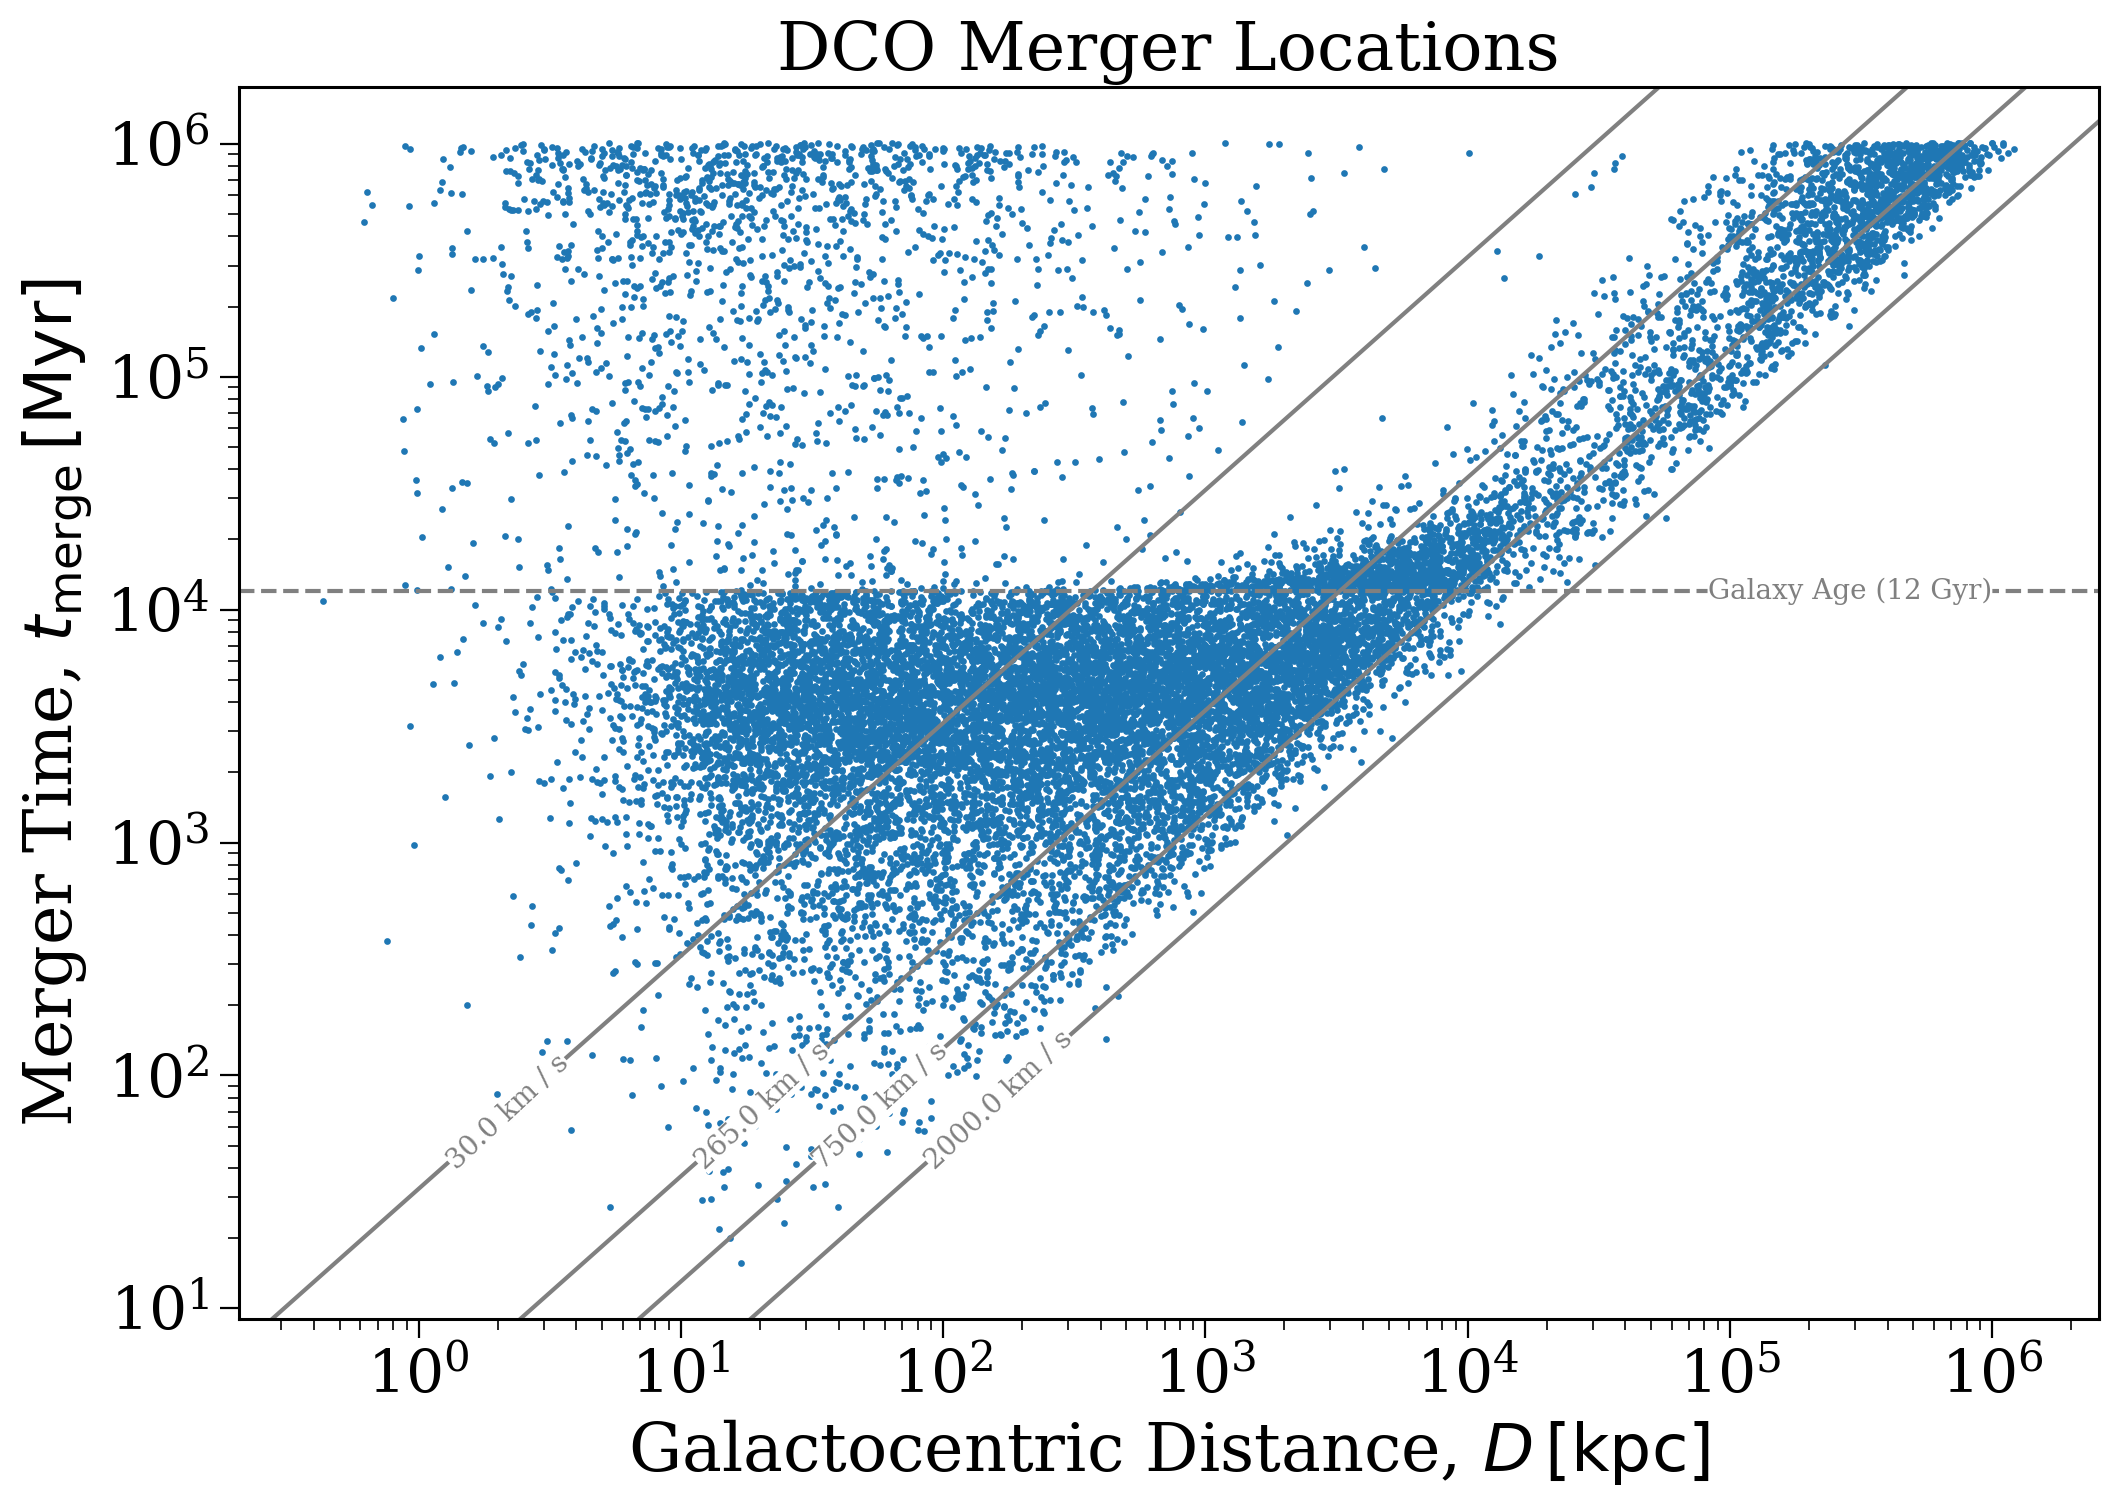

In [498]:
fig, ax = plt.subplots()

ax.scatter(df.loc[~df["has_merged"], "distance"].values,
           df.loc[~df["has_merged"], "t_merge"].values + 12000, s=2)
ax.scatter(df.loc[df["has_merged"]]["distance"].values,
           df.loc[df["has_merged"]]["t_merge"].values + df.loc[df["has_merged"], "birth_time"],
           s=2, color="tab:blue")


# ax.axhline(1e6, color='grey', linestyle="--")
ax.axhline(12e3, color="grey", linestyle="--")
ax.annotate("Galaxy Age (12 Gyr)", xy=(1e6, 12e3), color="grey", ha="right", va="center",
            bbox=dict(boxstyle="round", fc="white", ec="none", pad=0.01))

ax.set_yscale("log")
ax.set_xscale("log")

xlim = ax.get_xlim()
ylim = ax.get_ylim()

x_range = np.logspace(-1, 7, 1000) * u.kpc
for speed in [30, 265, 750, 2000] * u.km / u.s:
    y_vals = (x_range / speed).to(u.Myr).value
    ax.plot(x_range.value, y_vals, color="grey")
    ax.annotate(speed, xy=((4e1 * u.Myr * speed).to(u.kpc).value, 4e1),
                rotation=43, ha="left", zorder=10, color="grey",
                bbox=dict(boxstyle="round", fc="white", ec="none", pad=0.01))
    
ax.set_xlim(xlim)
ax.set_ylim(ylim)

plt.xlabel(r"Galactocentric Distance, $D \, [{\rm kpc}]$")
plt.ylabel(r"Merger Time, $t_{\rm merge} \, [{\rm Myr}]$")
plt.title("DCO Merger Locations", fontsize=fs)
plt.show()

# PLANS

Colour by kick velocity (1st or 2nd? Perhaps just final systemic velocity?)

Different markers based on whether escaped and DCO type.

In [70]:
(u.kpc / u.Myr).to(u.km / u.s)

977.7922216807891

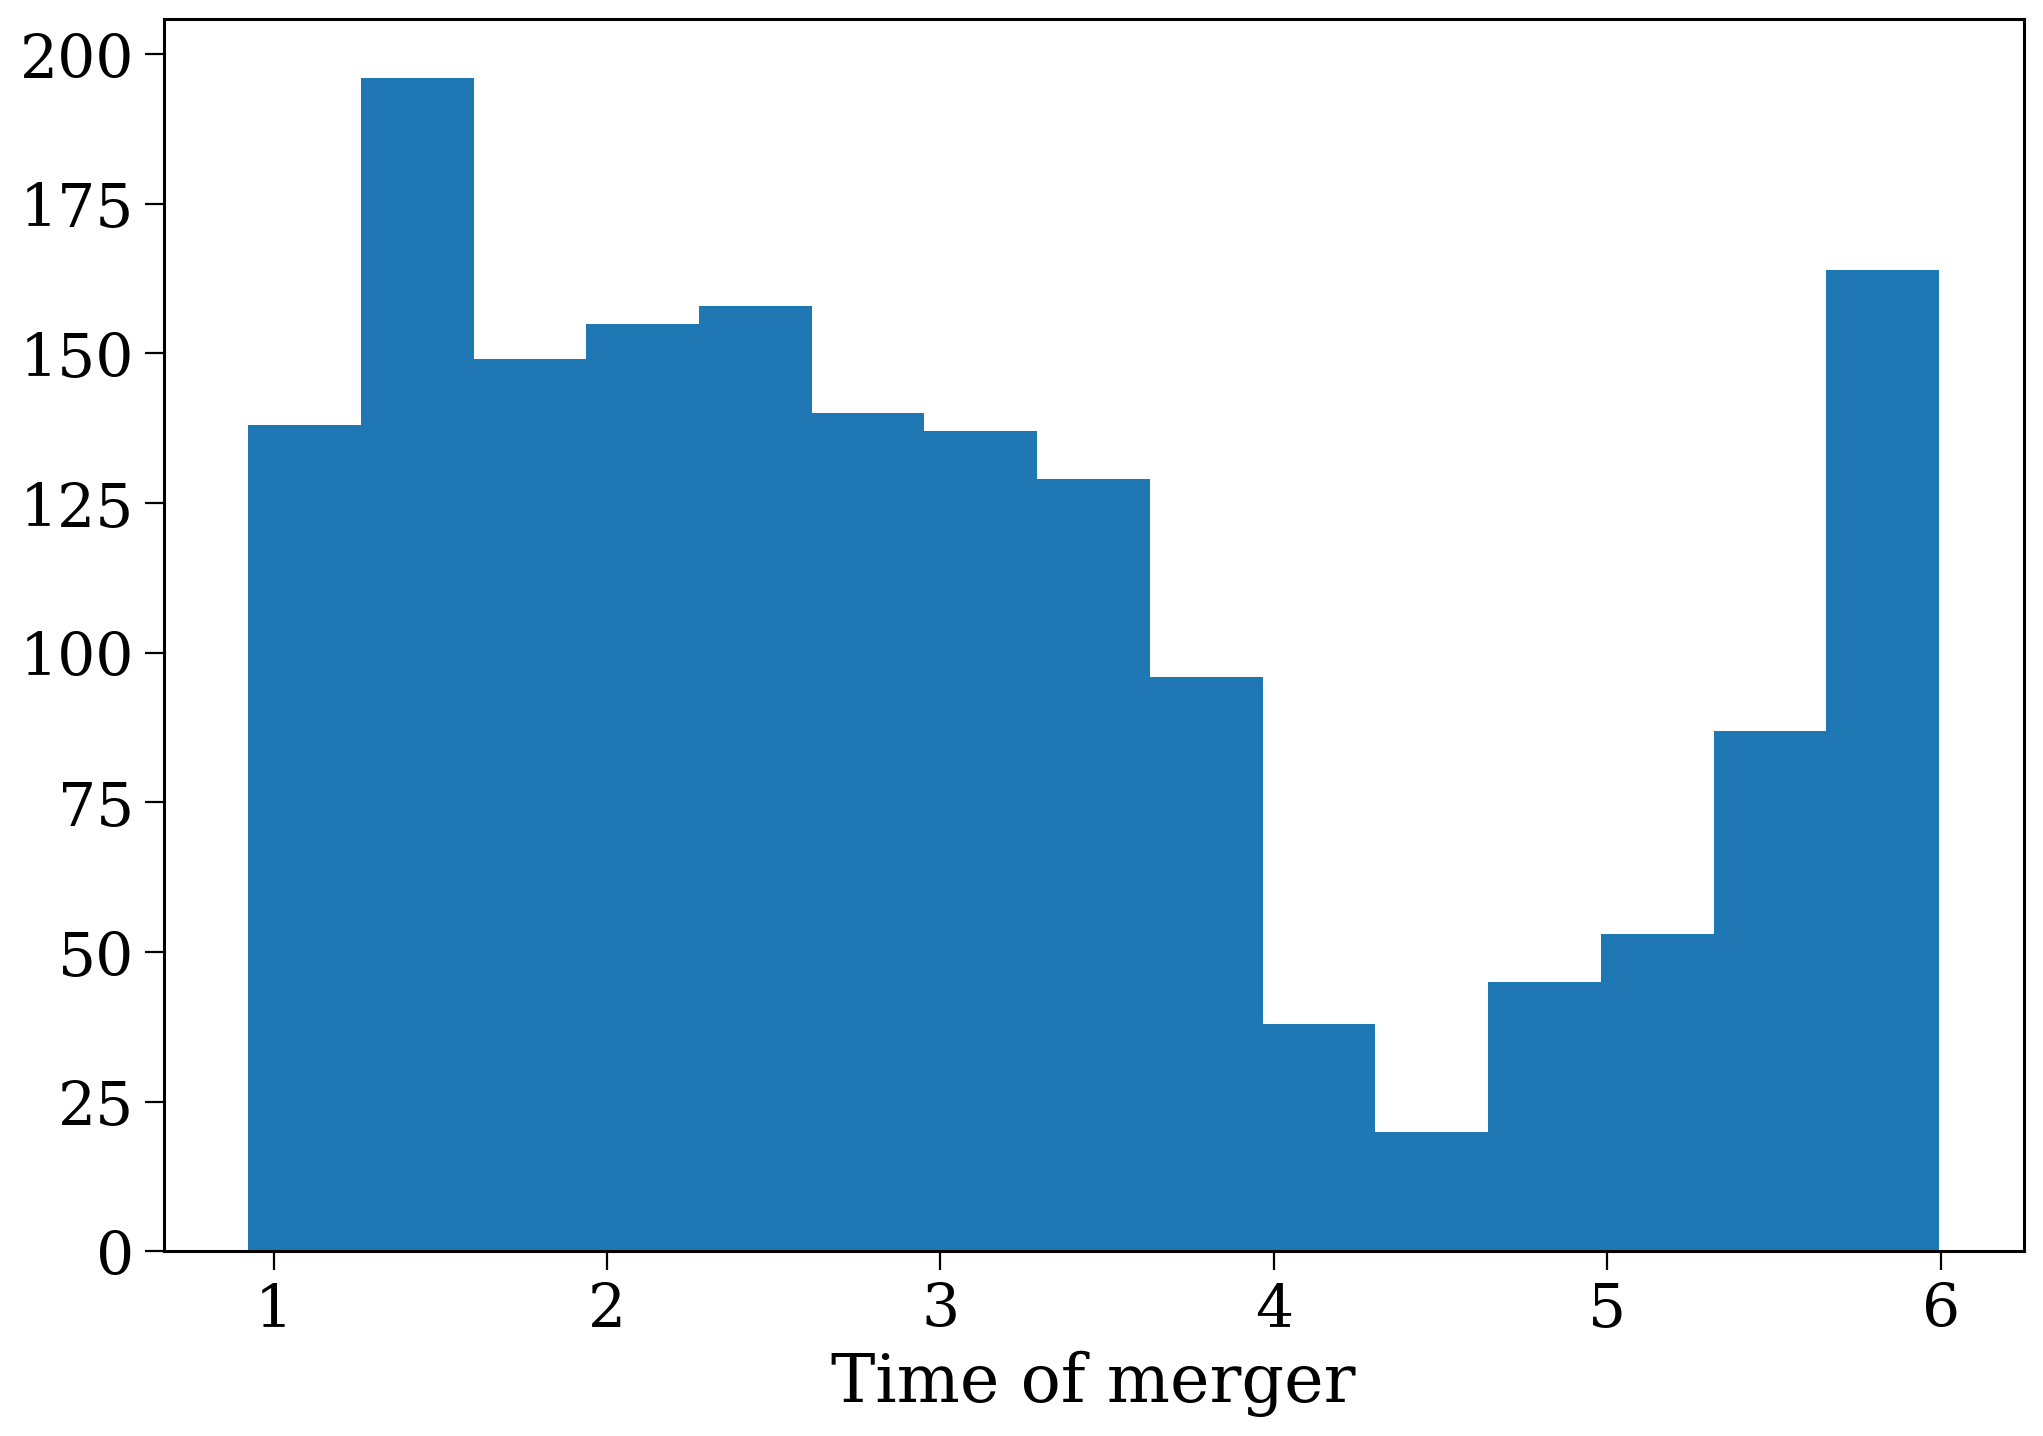

In [410]:
plt.hist(np.log10(df["t_merge"].values), bins="fd");
plt.xlabel(r"Time of merger")
plt.show()

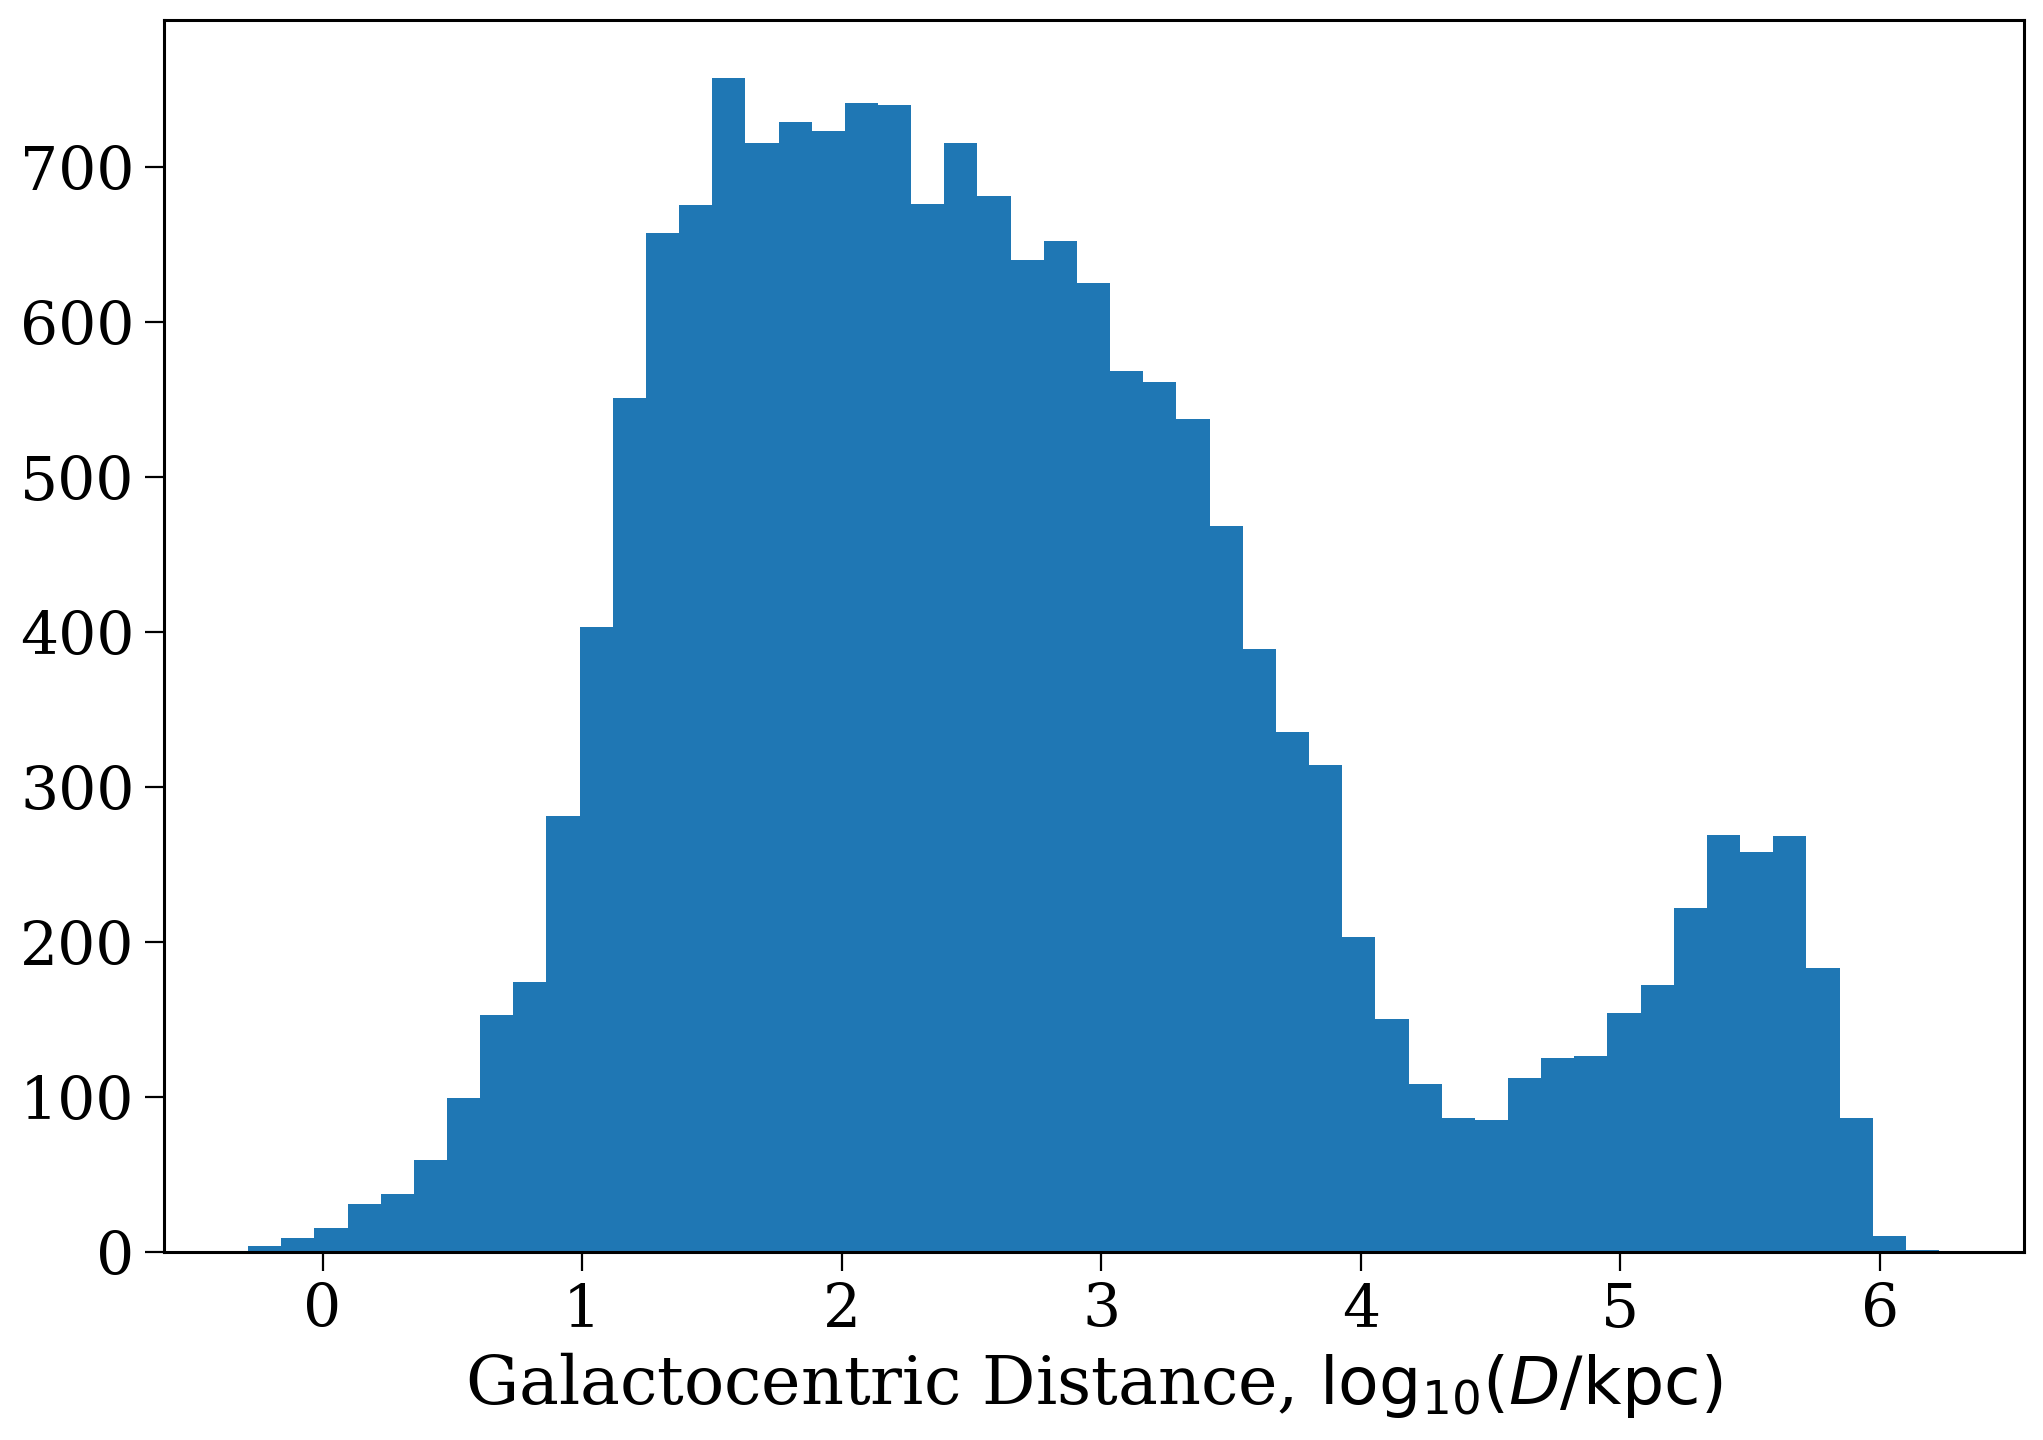

In [66]:
plt.hist(np.log10(df["distance"].values), bins="fd");
plt.xlabel(r"Galactocentric Distance, $\log_{10}(D / {\rm kpc})$")
plt.show()

In [19]:
ls data/

README.md                    merger-loc-times-2.h5  merger-loc-times-8.h5
filtered_sample.fits         merger-loc-times-3.h5  merger-loc-times-9.h5
future_merger_distances.npy  merger-loc-times-4.h5  past_merger_distances.npy
good_parallax_ids.npy        merger-loc-times-5.h5  target_sample.fits
merger-loc-times-0.h5        merger-loc-times-6.h5
merger-loc-times-1.h5        merger-loc-times-7.h5


In [12]:
d = np.concatenate((np.load("data/future_merger_distances.npy"), np.load("data/past_merger_distances.npy")))

(array([ 18.,  58.,  43.,  26.,  45.,  84.,  55., 147.]),
 array([-0.08085399,  0.67474297,  1.43033992,  2.18593688,  2.94153384,
         3.69713079,  4.45272775,  5.20832471,  5.96392166]),
 <BarContainer object of 8 artists>)

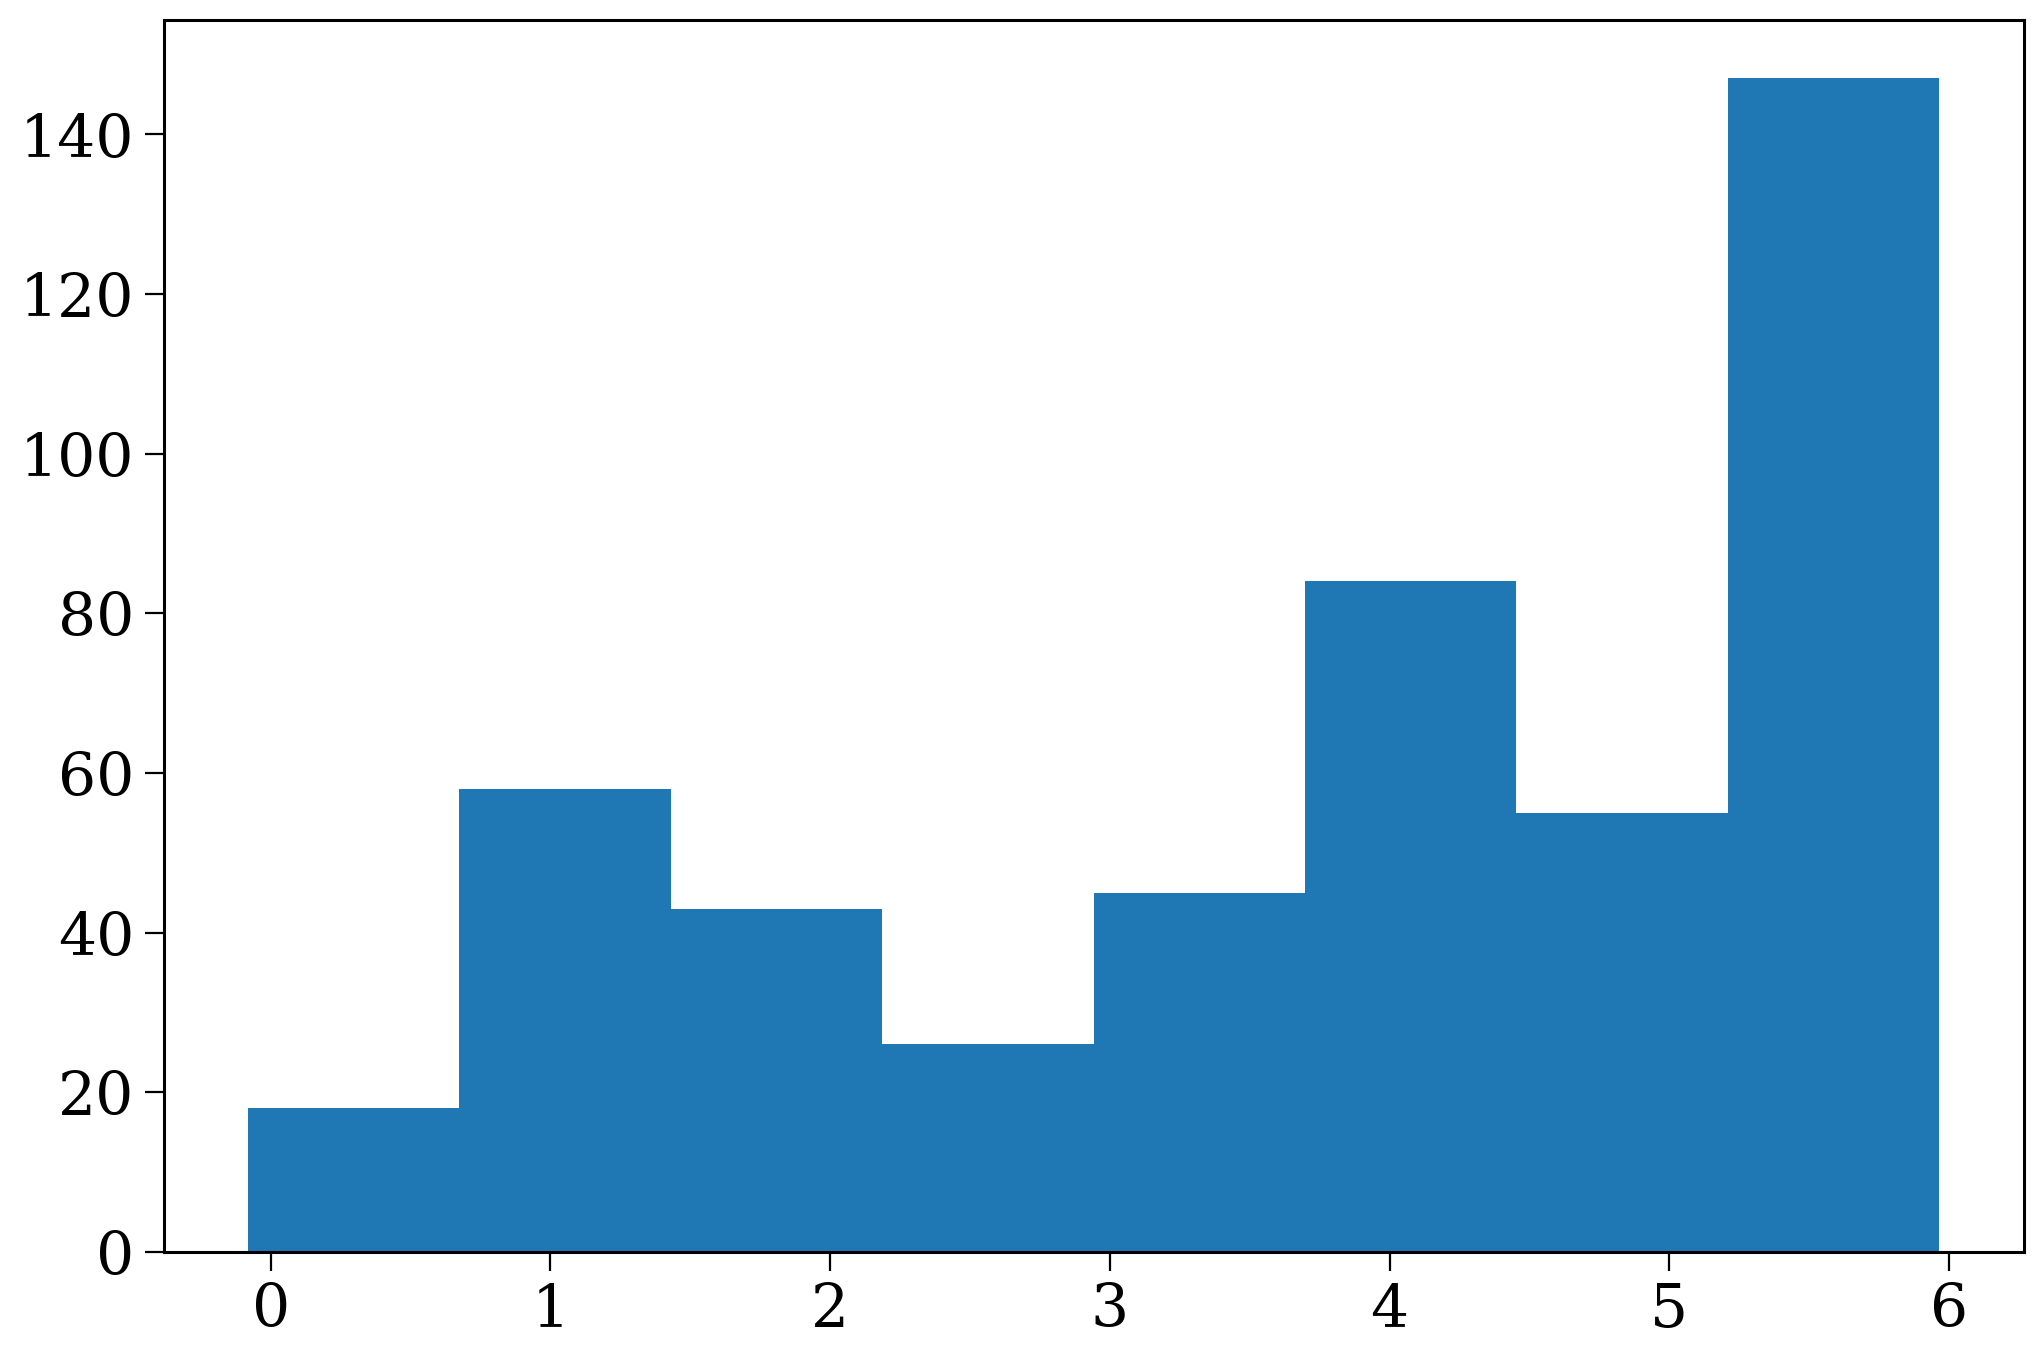

In [17]:
plt.hist(np.log10(np.load("data/past_merger_distances.npy")), bins="fd")